In [1]:
import CS_functions as cs
import numpy as np
from matplotlib import pyplot as plt
from scipy import fft as spfft
from scipy.constants import speed_of_light as C
plt.rcParams.update({'font.size':24, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})

In [2]:
peak_freqs = np.array([182e9, 273e9])
envelope_FWHM = 30 #mm
FWHM_freq = 40e9 # 41.497e9 # Hz. (almost?) Equivelent to 30mm FWHM envelope 
total_points = 50
pixel_pitch= 1.0 # mm
theta= 6.1 # degrees
regularization_coeffient = 1e-2
test_config = np.array([13,17,19,25,29,34,35,45])


displacement = np.arange(-(total_points//2), (total_points+1)//2) *pixel_pitch #in mm
target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta)

uncertainties = np.ones_like(target)

reduced_points = len(test_config)

detectors, score = cs.douglas_peucker(reduced_points, target, uncertainties, regularization_coeffient)
print(*detectors, sep= ",")

25,22,20,40,15,10,38,26


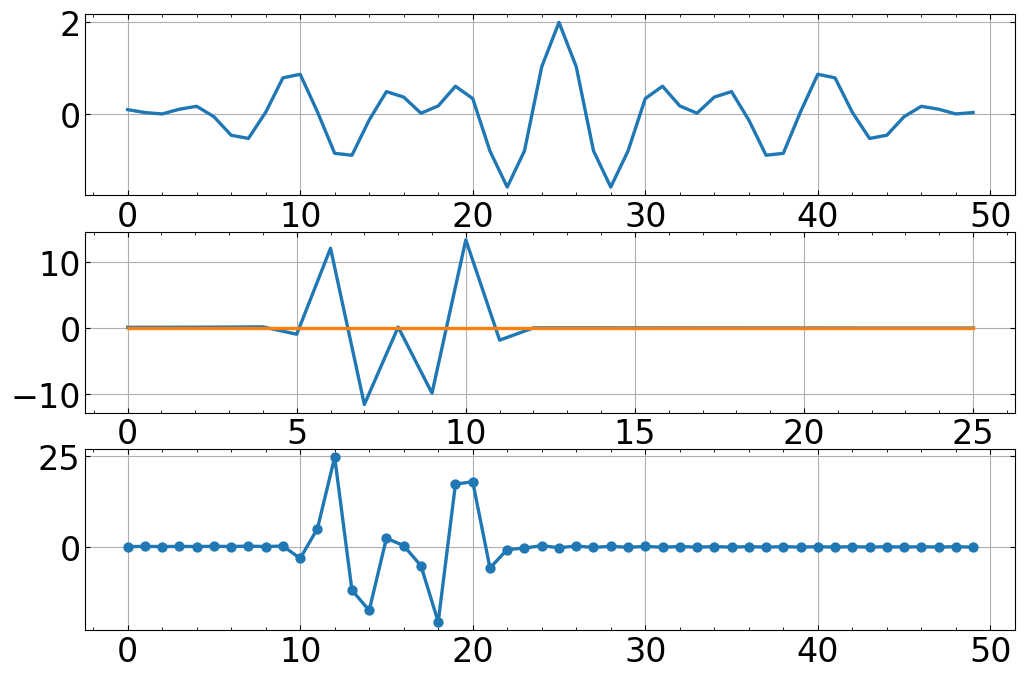

In [3]:
b = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta)
B_FFT = np.fft.rfft(b)
B_DCT = spfft.dct(b, type= 1)

fig, axs = plt.subplots(3, 1, figsize= (12, 8))

axs[0].plot(b)
axs[0].grid()

axs[1].plot(B_FFT.real)
axs[1].plot(B_FFT.imag)
axs[1].grid()

axs[2].plot(B_DCT, marker= ".")
axs[2].grid()

plt.show()

In [4]:
samples = np.full_like(target, np.nan)
samples[test_config] = target[test_config]
test_result = cs.compressed_sensing(samples, regularization_coeffient)

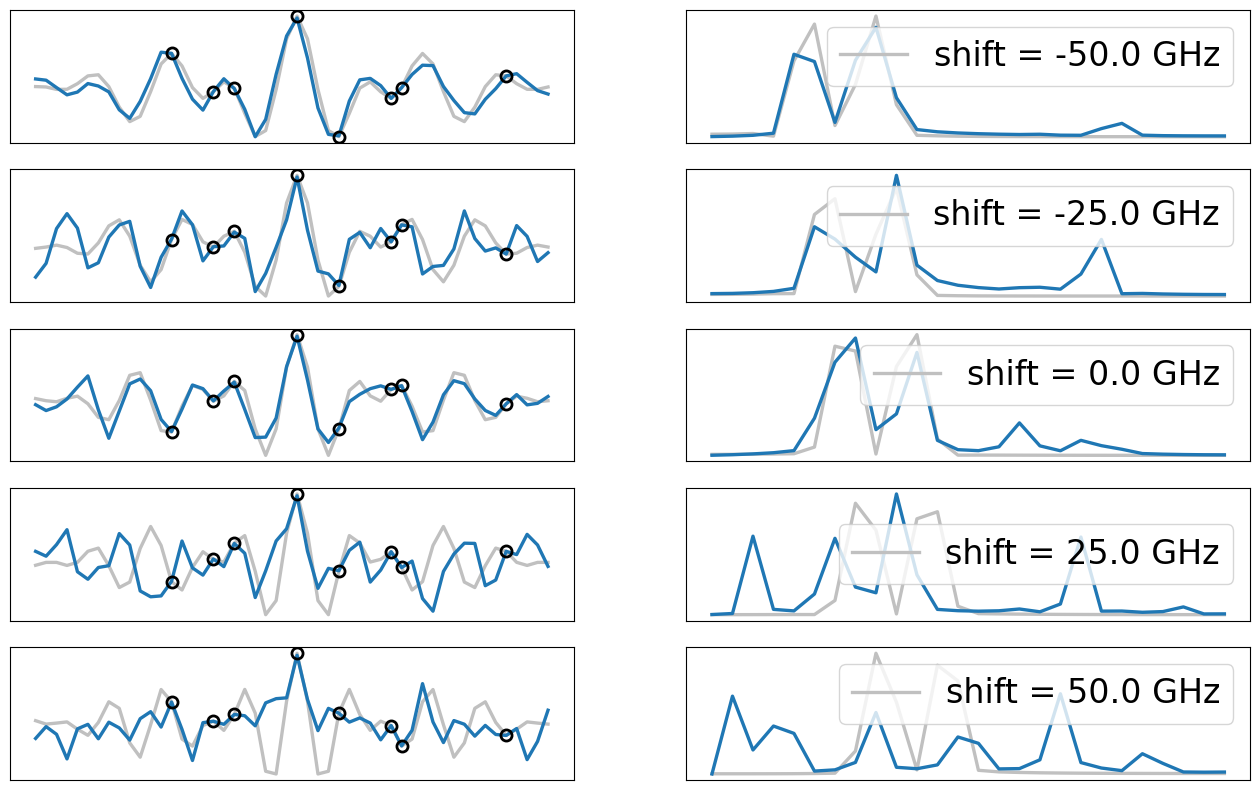

In [5]:
N = 5; shift_range= 50e9
shifts = np.linspace(-shift_range, shift_range, N)

fig, axs = plt.subplots(N, 2, figsize= (16, 2*N))

for ax, shift in zip(axs, shifts):

    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs +shift, envelope_FWHM*1e-3, theta)

    uncertainties = np.ones_like(target)

    samples = np.full_like(target, np.nan)
    samples[test_config] = target[test_config]
    test_result = cs.compressed_sensing(samples, regularization_coeffient, norm= "ortho")

    ax[0].plot(target, color= "silver", label= "actual signal")
    ax[0].plot(test_result, color= "tab:blue", label= "")
    ax[0].plot(test_config, target[test_config], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8, label= "samples")
    ax[0].set(xticks= [], yticks= [])

    target_FFT = np.fft.rfft(target)
    target_FFT = np.abs(target_FFT)
    reconstruction_FFT = np.fft.rfft(test_result)
    reconstruction_FFT = np.abs(reconstruction_FFT)

    ax[1].plot(target_FFT, color= "silver", label= f"shift = {shift*1e-9} GHz")
    ax[1].plot(reconstruction_FFT, color= "tab:blue")
    ax[1].set(xticks= [], yticks= [])
    ax[1].legend()

plt.show()

In [6]:
test_config

array([13, 17, 19, 25, 29, 34, 35, 45])

WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data n

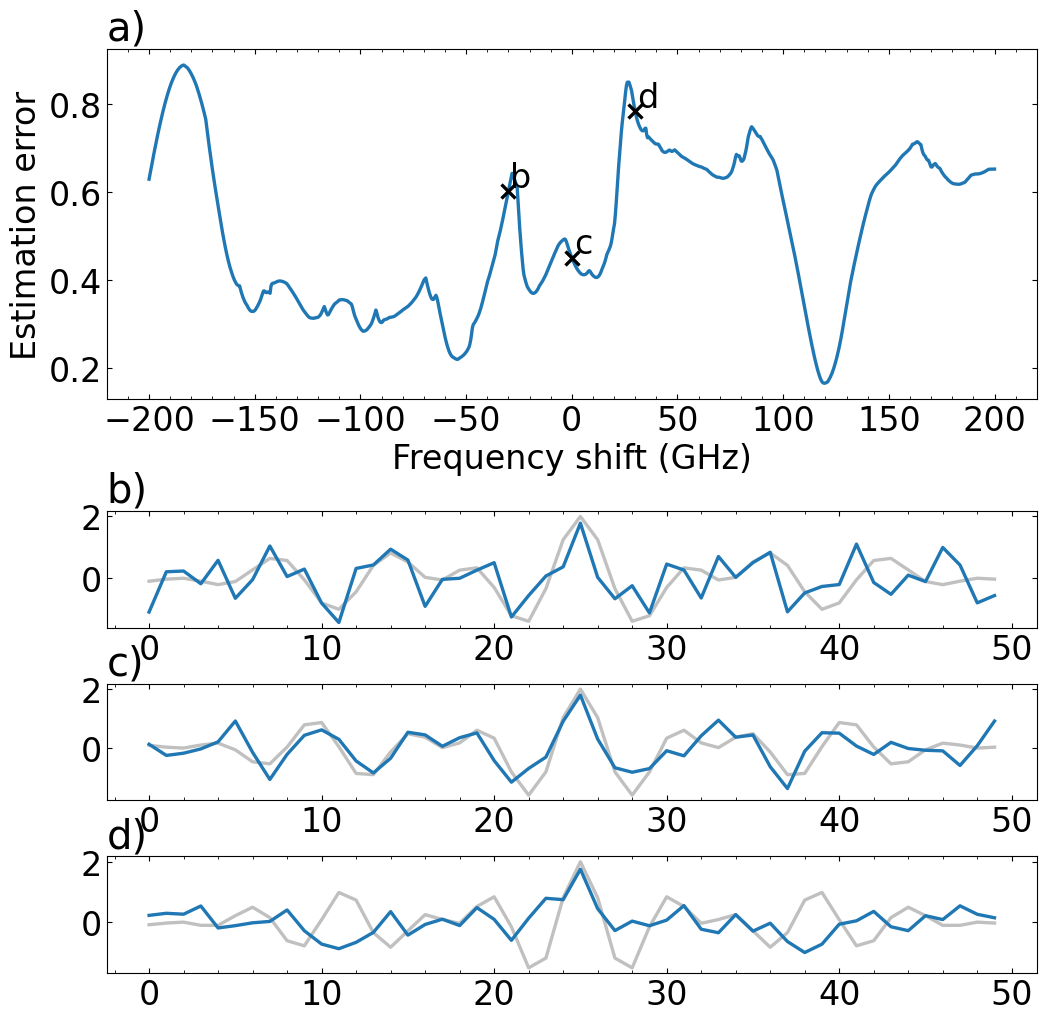

In [23]:
N = 1000; shift_range= 200e9
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs +shift, envelope_FWHM*1e-3, theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient= regularization_coeffient, error_type= "L2")

examples = {}
examples["shift"] = [-30e9, 0, 30e9]
examples["target"] = [cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs +shift, envelope_FWHM*1e-3, theta) for shift in examples["shift"]]
examples["uncertainty"] = [np.ones_like(target) for target in examples["target"]]
examples["score"] = [cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient= regularization_coeffient, error_type= "L2") for target, uncertainties in zip(examples["target"], examples["uncertainty"])]
examples["samples"] = [np.full_like(target, np.nan) for target in examples["target"]]
for samples, target in zip(examples["samples"], examples["target"]): samples[test_config] = target[test_config]
examples["reconstruction"] = [cs.compressed_sensing(samples, regularization_coeffient) for samples in examples["samples"]]

fig, axs = plt.subplots(5, 1, figsize= (12, 12), height_ratios= (3,0,1,1,1), gridspec_kw= {"hspace": 0.4})

axs[0].plot(shifts*1e-9, scores)
axs[0].set(xlabel= "Frequency shift (GHz)", ylabel= "Estimation error")
axs[0].set_title("a)", loc='left')

axs[1].set_axis_off()

for ax, target, reconstruction, shift, score, title in zip(axs[2:], examples["target"], examples["reconstruction"], examples["shift"], examples["score"], ["b)","c)","d)"]):
    ax.plot(target, color= "silver")
    ax.plot(reconstruction)
    ax.set_title(title, loc= "left")
    axs[0].plot(shift*1e-9, score, marker= "x", color= "k")
    axs[0].text(shift*1e-9 +1, score +0.01, title.removesuffix(")"))

fig.savefig("./graphs/frequency_shift_robustness.png")
plt.show()


WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data n

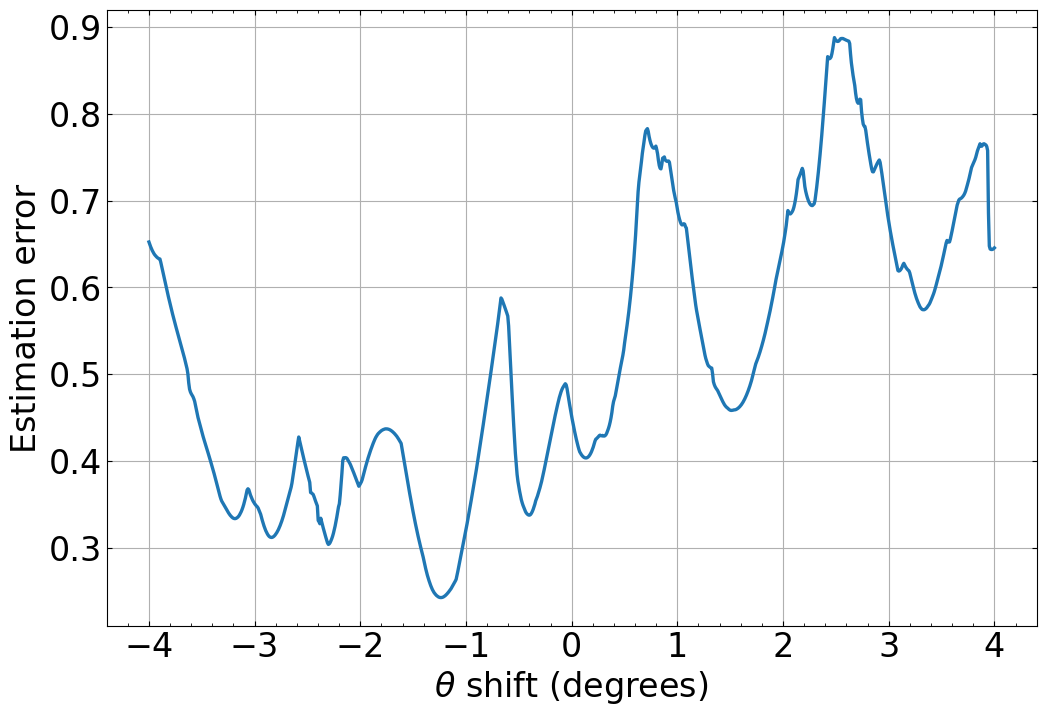

In [24]:
N = 1000; shift_range= 4.0
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta +shift)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient= regularization_coeffient, error_type= "L2")

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts, scores)
axs.set(xlabel= r"$\theta$ shift (degrees)", ylabel= "Estimation error")

plt.grid()
plt.show()


WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data n

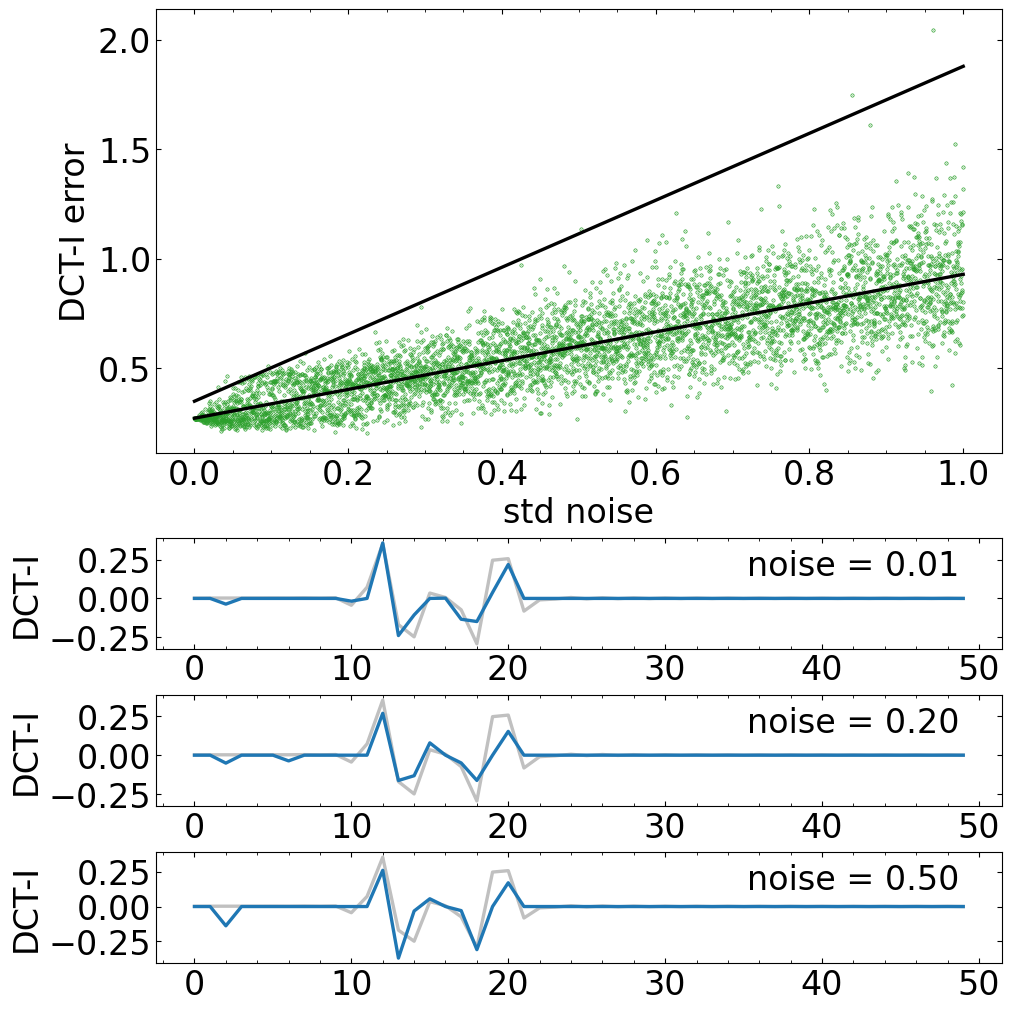

In [31]:
N = 5000; max_noise= 1.0; regularization_coeffient= 1e-2 #max_noise*1.3

noises = np.linspace(1e-4, max_noise, N)
RSS = np.empty(N); L2 = np.empty(N); theory = np.empty(N)

examples = {"noise": [0.01, 0.2, 0.5],
            "reconstructed": [],
            "target": []}
examples["noise"] = [cs.closest(noises, noises, noise) for noise in examples["noise"]]

a = 0

for n, noise in enumerate(noises):
    c = 1
    tau = 2
    offset = 0.35

    #lambda_N = 2 *noise *np.sqrt( tau *np.log10(p) /len(test_config) )
    #print(regularization_coeffient, lambda_N)
    #regularization_coeffient = lambda_N

    allnoise = np.random.normal(0, noise,  total_points)
    noiseless = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta)
    target = noiseless +allnoise
    uncertainties = np.full_like(target, noise)
    if np.linalg.norm(allnoise[test_config], ord= np.inf) <= noise:
        a += 1

    RSS[n] = cs.evaluate_score(test_config, target, regularization_coeffient= regularization_coeffient, error_type= "RSS")

    sample = np.full_like(target, np.nan)
    sample[detectors] = target[detectors]
    result_DCT = cs.compressed_sensing(sample, regularization_coeffient, domain= "DCT", dct_type= 1)
    result = cs.compressed_sensing(sample, regularization_coeffient, domain= "IDCT", dct_type= 1)
    noiseless_DCT = spfft.dct(noiseless, norm= "ortho", type= 1) /np.sqrt(total_points)
    target_DCT = spfft.dct(target, norm= "ortho", type= 1) /np.sqrt(total_points)
    L2[n] = cs.evaluate_score(test_config, target, uncertainties, noiseless, regularization_coeffient= regularization_coeffient, error_type= "L2")
    # RSS[n] = np.linalg.norm(target -noiseless)**2

    k = np.count_nonzero(np.abs(noiseless_DCT) > 1e-2)
    p = len(target_DCT)
    theory[n] = c *noise *np.sqrt( k *np.log10(p) /len(test_config) ) + offset

    for m in examples["noise"]:
        if m == noise:
            examples["reconstructed"] += [result_DCT]
            examples["target"] += [noiseless_DCT]
            print("Example saved!")
print(k, a/N)

fig, axs = plt.subplots(4, 1, figsize= (10, 10), height_ratios= (4, 1, 1, 1), layout= "constrained")

axs[0].plot(noises, L2, color= "tab:green", linestyle= "none", marker= ".", markersize= 1)
axs[0].set(ylabel= "DCT-I error", xlabel= "std noise")
best_fit = np.polyfit(noises, L2, 1)
print(best_fit)
axs[0].plot(noises, best_fit[-1] +best_fit[-2]*noises, color= "k")
axs[0].plot(noises, theory, color= "k")


for ax, reconstructed, target, noise in zip(axs[1:], examples["reconstructed"], examples["target"], examples["noise"]):
    ax.plot(target, color= "silver")
    ax.plot(reconstructed)
    ax.set(ylabel= "DCT-I")
    ax.text(0.95, 0.9, f"noise = {noise:.2f}", transform= ax.transAxes, ha= "right", va= "top")

plt.show()

[ 0.21554782 -0.00477449  0.19998814]
[0.20615308 0.14954245 0.19939826]
[0.21217445 0.40019501 0.10065522]
[ 0.26502593  0.70345798 -0.06864433]
[ 0.35164435  0.82549159 -0.0044829 ]
[ 0.38191955  1.07636858 -0.03431897]
[0.42384016 0.89769532 0.7632154 ]


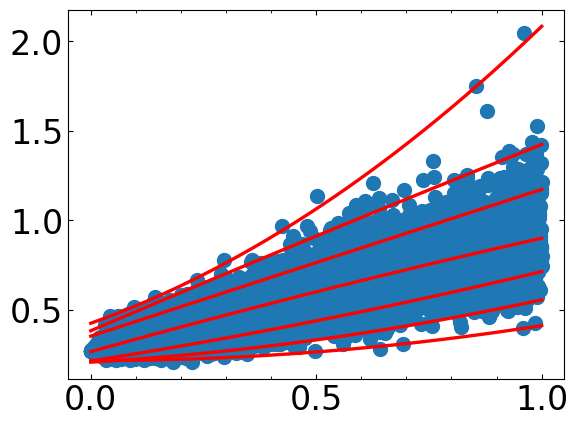

In [32]:
import statsmodels.api as sm
import numpy as np

# x and y are your data arrays
quantile = 0.99  # 99th percentile

X = np.column_stack([np.ones_like(noises), noises, noises**2]) # == X = np.array([np.ones_like(noises), noises, noises**2]).T
model = sm.QuantReg(L2, X)

fits = []
for quantile in [0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999]:
    res = model.fit(q=quantile)
    print(res.params)
    fit = res.predict(X)
    fits += [fit]

import matplotlib.pyplot as plt
plt.scatter(noises, L2)
for fit in fits:
    plt.plot(noises, fit, color='red')
#plt.plot(noises, theory, color= "k")
plt.show()

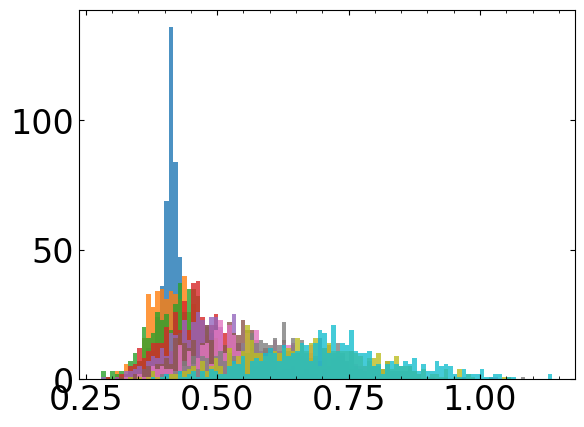

In [11]:
for n in np.arange(0.0, 1.1, 0.1):
    plt.hist(L2[(n < noises) & (noises <= n+0.1)], bins= 100, alpha= 0.8, range= (L2.min(), L2.max()))
plt.show()

0.06 0.00013034454358875245
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.06 0.00039105970488979977
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.06 0.0006517748661908472
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.06 0.0009124900274918946
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.06 0.0011732051887929419
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.06 0.0014339203500939892
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.06 0.0016946355113950367
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.06 0.001955350672696084
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.06 0.0022160658339971315
WARNING! Noiseless data not provided, assuming interferogram has no noise.
0.06 0.0024767809952981786
WARNING! Noiseless data not provided, assuming interfe

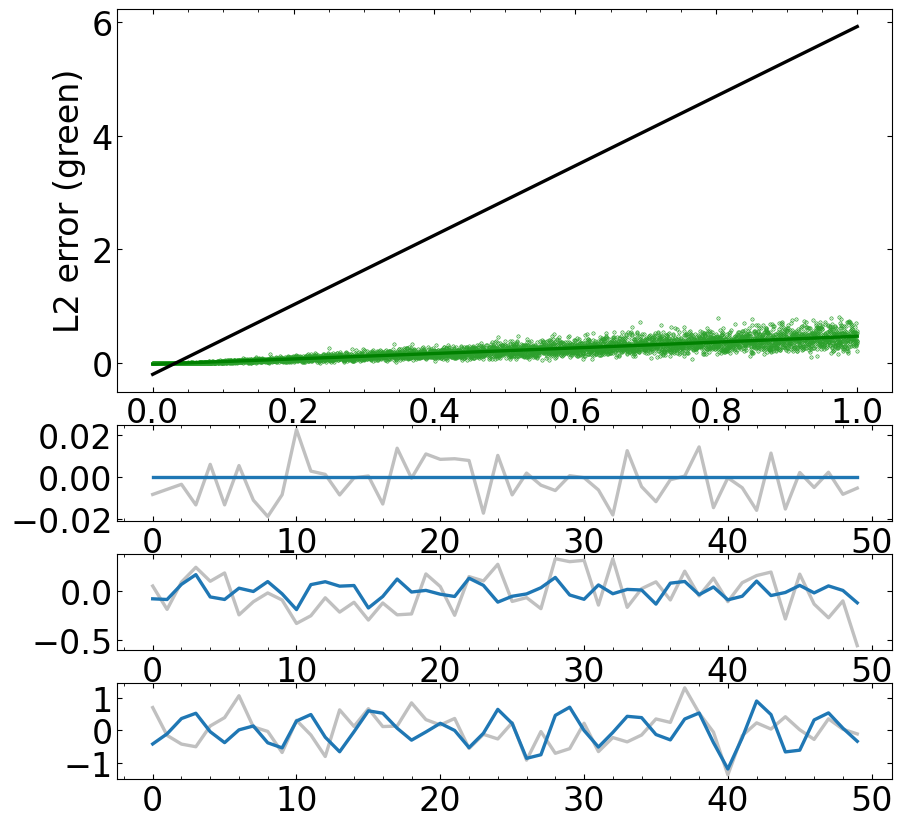

In [12]:
examples["reconstructed"] = []
examples["target"] = []

for n, noise in enumerate(noises):
    c = 5
    offset = -0.2
    tau = 2
    k = np.count_nonzero(np.abs(noiseless_DCT) > 1e-2)
    theory[n] = c *noise *np.sqrt( k *np.log10(np.e *len(target_DCT) /k) /len(test_config) ) + offset
    lambda_N = 2 *noise *np.sqrt( tau *np.log10(len(target_DCT)) /len(test_config) )
    print(regularization_coeffient, lambda_N)
    #regularization_coeffient = lambda_N

    allnoise = np.random.normal(0, noise,  total_points)
    zeros = np.zeros_like(allnoise)

    RSS[n] = cs.evaluate_score(test_config, allnoise, regularization_coeffient= regularization_coeffient, error_type= "RSS")

    sample = np.full_like(allnoise, np.nan)
    sample[detectors] = allnoise[detectors]
    result_DCT = cs.compressed_sensing(sample, regularization_coeffient, domain= "DCT", dct_type= 1)
    result = cs.compressed_sensing(sample, regularization_coeffient, domain= "IDCT", dct_type= 1)
    zeros_DCT = spfft.dct(zeros, norm= "forward", type= 1)
    allnoise_DCT = spfft.dct(allnoise, norm= "forward", type= 1)
    L2[n] = np.linalg.norm(result_DCT -zeros_DCT)

    for m in examples["noise"]:
        if m == noise:
            examples["reconstructed"] += [result]
            examples["target"] += [allnoise]
            print("Example saved!")
            

fig, axs = plt.subplots(4, 1, figsize= (10, 10), height_ratios= (4, 1, 1, 1))

axs[0].plot(noises, L2, color= "tab:green", linestyle= "none", marker= ".", markersize= 1)
axs[0].set(ylabel= "L2 error (green)")
best_fit = np.polyfit(noises, L2, 2)
print(best_fit)
axs[0].plot(noises, best_fit[-1] +best_fit[-2]*noises +best_fit[-3]*noises**2, color= "green")
axs[0].plot(noises, theory, color= "k")


for ax, reconstructed, target in zip(axs[1:], examples["reconstructed"], examples["target"]):
    ax.plot(target, color= "silver")
    ax.plot(reconstructed)

plt.show()

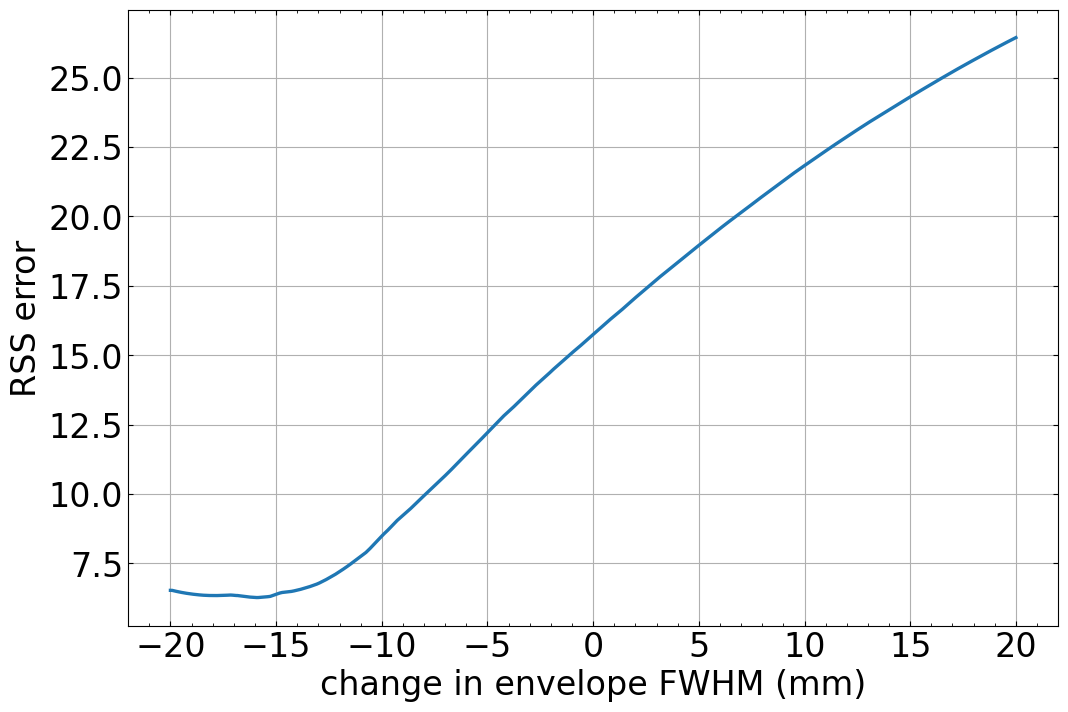

In [13]:
N = 1000; shift_range= 20
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, (envelope_FWHM +shift)*1e-3, theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts, scores)
axs.set(xlabel= r"change in envelope FWHM (mm)", ylabel= "RSS error")

plt.grid()
plt.show()

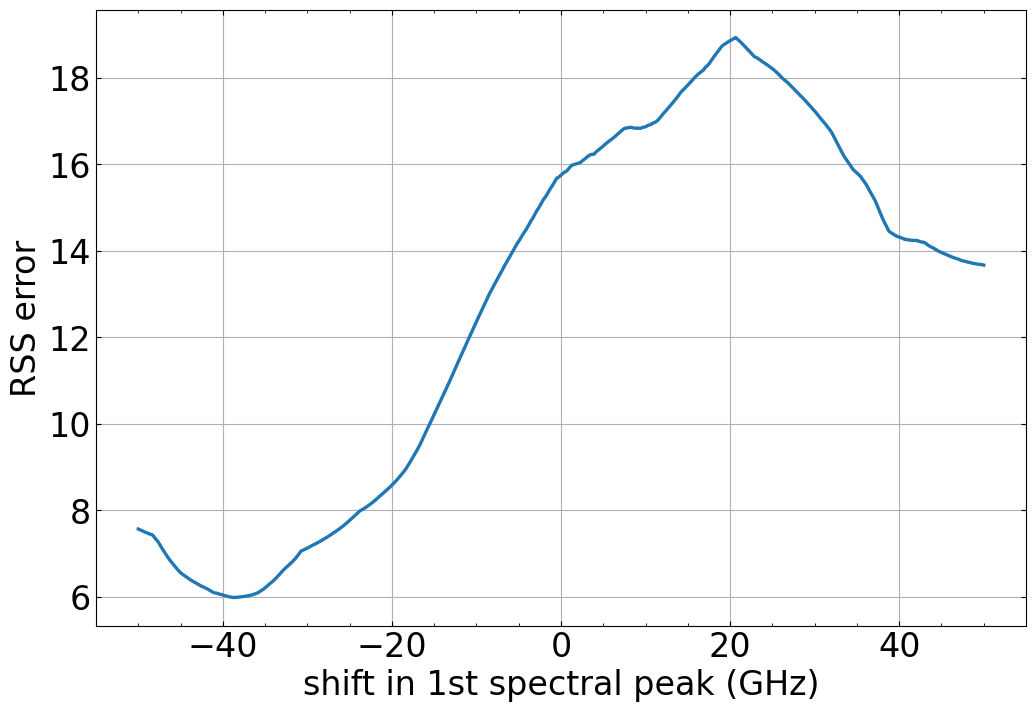

In [14]:
N = 1000; shift_range= 50e9
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, (peak_freqs[0]+shift, peak_freqs[1]), envelope_FWHM*1e-3, theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts*1e-9, scores)
axs.set(xlabel= "shift in 1st spectral peak (GHz)", ylabel= "RSS error")

plt.grid()
plt.show()

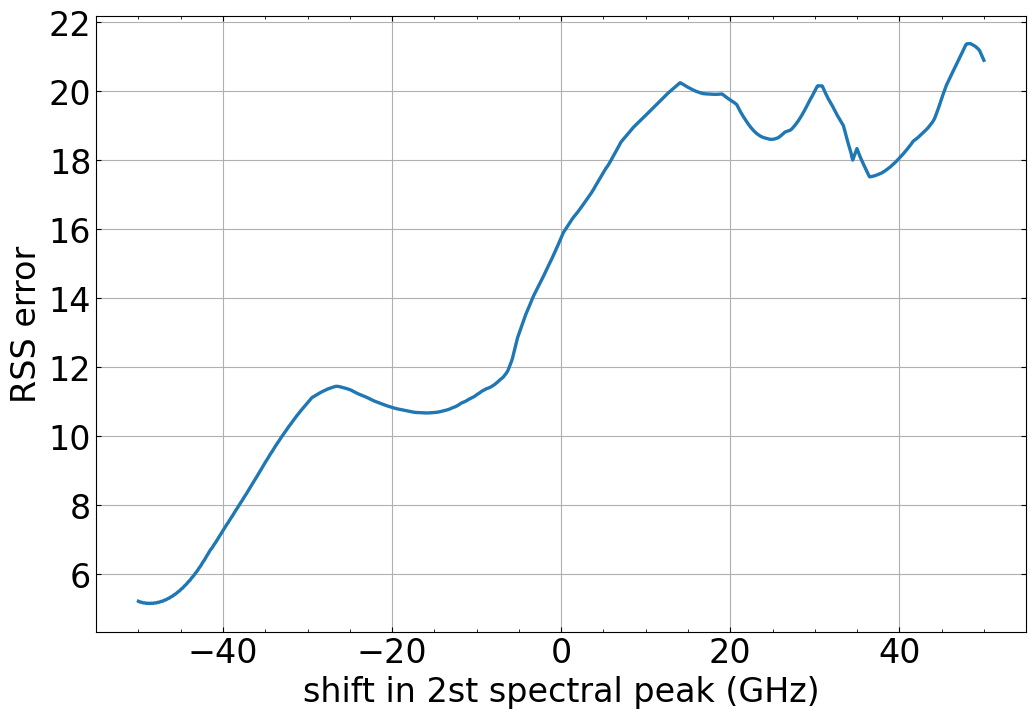

In [15]:
N = 1000; shift_range= 50e9
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, (peak_freqs[0], peak_freqs[1]+shift), envelope_FWHM*1e-3, theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts*1e-9, scores)
axs.set(xlabel= "shift in 2st spectral peak (GHz)", ylabel= "RSS error")

plt.grid()
plt.show()

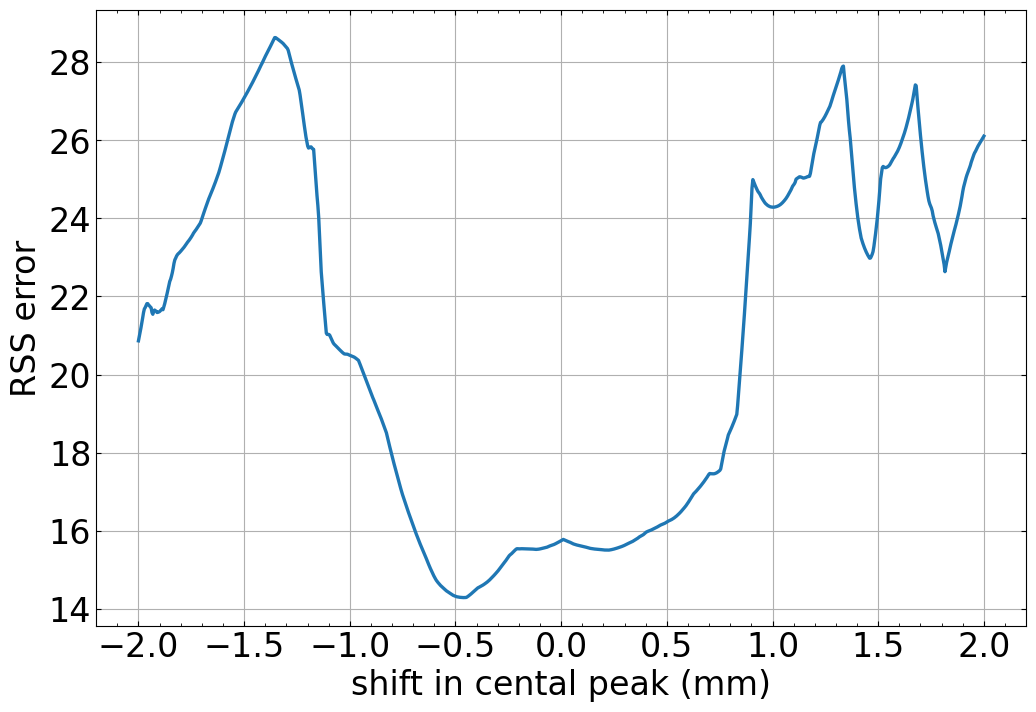

In [16]:
N = 1000; shift_range= 2
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta, displacement_shift= shift*1e-3)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts, scores)
axs.set(xlabel= "shift in cental peak (mm)", ylabel= "RSS error")

plt.grid()
plt.show()